# WARNING
**Please make sure to "COPY AND EDIT NOTEBOOK" to use compatible library dependencies! DO NOT CREATE A NEW NOTEBOOK AND COPY+PASTE THE CODE - this will use latest Kaggle dependencies at the time you do that, and the code will need to be modified to make it work. Also make sure internet connectivity is enabled on your notebook**

# Preliminaries
First install critical dependencies not already on the Kaggle docker image. **NOTE THAT THIS NOTEBOOK USES TENSORFLOW 1.14 IN ORDER TO BE COMPARED WITH ELMo, WHICH WAS NOT PORTED TO TENSORFLOW 2.X. To see equivalent Tensorflow 2.X BERT Code for the Spam problem, see https://www.kaggle.com/azunre/tlfornlp-chapters2-3-spam-bert-tf2** 

In [88]:
!pip install keras==2.2.4 # critical dependency
!pip install -q bert-tensorflow==1.0.1

Write requirements to file, anytime you run it, in case you have to go back and recover Kaggle dependencies. **MOST OF THESE REQUIREMENTS WOULD NOT BE NECESSARY FOR LOCAL INSTALLATION**

Latest known such requirements are hosted for each notebook in the companion github repo, and can be pulled down and installed here if needed. Companion github repo is located at https://github.com/azunre/transfer-learning-for-nlp

In [89]:
!pip freeze > kaggle_image_requirements.txt

In [90]:
# Import neural network libraries
import tensorflow as tf
import tensorflow_hub as hub
from bert.tokenization import FullTokenizer
from tensorflow.keras import backend as K

# Initialize session
sess = tf.Session()

In [91]:
# Some other key imports
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm

# Define Tokenization, Stop-word and Punctuation Removal Functions

Before proceeding, we must decide how many samples to draw from each class. We must also decide the maximum number of tokens per email, and the maximum length of each token. This is done by setting the following overarching hyperparameters

In [92]:
# Params for bert model and tokenization
Nsamp = 1000 # number of samples to generate in each class - 'spam', 'not spam'
maxtokens = 230 # the maximum number of tokens per document
maxtokenlen = 200 # the maximum length of each token

Tokenization

In [93]:
def tokenize(row):
    if row is None or row is '':
        tokens = ""
    else:
        try:
            tokens = row.split(" ")[:maxtokens]
        except:
            tokens=""
    return tokens

**Use regular expressions to remove unnecessary characters**

Next, we define a function to remove punctuation marks and other nonword characters (using regular expressions) from the emails with the help of the ubiquitous python regex library. In the same step, we truncate all tokens to hyperparameter maxtokenlen defined above.

In [94]:
def reg_expressions(row):
    tokens = []
    try:
        for token in row:
            token = token.lower()
            token = re.sub(r'[\W\d]', "", token)
            token = token[:maxtokenlen] # truncate token
            tokens.append(token)
    except:
        token = ""
        tokens.append(token)
    return tokens

**Stop-word removal**

Let’s define a function to remove stopwords - words that occur so frequently in language that they offer no useful information for classification. This includes words such as “the” and “are”, and the popular library NLTK provides a heavily-used list that will employ.

In [95]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')    

# print(stopwords) # see default stopwords
# it may be beneficial to drop negation words from the removal list, as they can change the positive/negative meaning
# of a sentence - but we didn't find it to make a difference for this problem
# stopwords.remove("no")
# stopwords.remove("nor")
# stopwords.remove("not")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [96]:
def stop_word_removal(row):
    token = [token for token in row if token not in stopwords]
    token = filter(None, token)
    return token

# Download and Assemble IMDB Review Dataset

Download the labeled IMDB reviews

In [97]:
!wget -q "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
!tar xzf aclImdb_v1.tar.gz

Shuffle and preprocess data

In [98]:
# function for shuffling data
def unison_shuffle(data, header):
    p = np.random.permutation(len(header))
    data = data[p]
    header = np.asarray(header)[p]
    return data, header

def load_data(path):
    data, sentiments = [], []
    for folder, sentiment in (('neg', 0), ('pos', 1)):
        folder = os.path.join(path, folder)
        for name in os.listdir(folder):
            with open(os.path.join(folder, name), 'r') as reader:
                  text = reader.read()
            text = tokenize(text)
            text = stop_word_removal(text)
            text = reg_expressions(text)
            data.append(text)
            sentiments.append(sentiment)
    data_np = np.array(data)
    data, sentiments = unison_shuffle(data_np, sentiments)
    
    return data, sentiments

train_path = os.path.join('aclImdb', 'train')
test_path = os.path.join('aclImdb', 'test')
raw_data, raw_header = load_data(train_path)

print(raw_data.shape)
print(len(raw_header))

(25000,)
25000


In [99]:
# Subsample required number of samples
random_indices = np.random.choice(range(len(raw_header)),size=(Nsamp*2,),replace=False)
data_train = raw_data[random_indices]
header = raw_header[random_indices]

print("DEBUG::data_train::")
print(data_train)

DEBUG::data_train::
[list(['we', 'could', 'still', 'use', 'black', 'adder', 'even', 'today', 'imagine', 'rowan', 'atkinson', 'resuming', 'role', 'assistant', 'prime', 'minister', 'played', 'wonderful', 'hugh', 'laurie', 'hugh', 'sensational', 'dimwit', 'prince', 'george', 'edmund', 'brilliant', 'assistant', 'i', 'love', 'episode', 'kenneth', 'connor', 'guest', 'stars', 'british', 'thespian', 'every', 'time', 'edmund', 'says', 'macbeth', 'the', 'two', 'thespians', 'silly', 'little', 'act', 'ward', 'evil', 'spirits', 'its', 'funniest', 'things', 'see', 'of', 'course', 'none', 'brilliance', 'comedic', 'genius', 'could', 'without', 'ben', 'elton', 'richard', 'curtis', 'also', 'behind', 'films', 'like', 'love', 'actually', 'the', 'thin', 'blue', 'line', 'four', 'weddings', 'a', 'funeral', 'black', 'adder', 'funny', 'almost', 'good', 'television', 'humor', 'smart', 'sexy', 'funny', 'one', 'i', 'hoping', 'last', 'night', 'saturday', 'night', 'live', 'hugh', 'laurie', 'would', 'pay', 'homage',

Display sentiments and their frequencies in the dataset, to ensure it is roughly balanced between classes

In [100]:
unique_elements, counts_elements = np.unique(header, return_counts=True)
print("Sentiments and their frequencies:")
print(unique_elements)
print(counts_elements)

Sentiments and their frequencies:
[0 1]
[1015  985]


In [101]:
# function for converting data into the right format, due to the difference in required format from sklearn models
# we expect a single string per email here, versus a list of tokens for the sklearn models previously explored
def convert_data(raw_data,header):
    converted_data, labels = [], []
    for i in range(raw_data.shape[0]):
        # combine list of tokens representing each email into single string
        out = ' '.join(raw_data[i])
        converted_data.append(out)
        labels.append(header[i])
    converted_data = np.array(converted_data, dtype=object)[:, np.newaxis]
    
    return converted_data, np.array(labels)

data_train, header = unison_shuffle(data_train, header)

# split into independent 70% training and 30% testing sets
idx = int(0.7*data_train.shape[0])
# 70% of data for training
train_x, train_y = convert_data(data_train[:idx],header[:idx])
# remaining 30% for testing
test_x, test_y = convert_data(data_train[idx:],header[idx:])

print("train_x/train_y list details, to make sure it is of the right form:")
print(len(train_x))
print(train_x)
print(train_y[:5])
print(train_y.shape)

train_x/train_y list details, to make sure it is of the right form:
1400
[['one b cmovie producer roger cormans greatest cult classics ramones vehicle originally designated cheap trick rock n roll high school its simple technically dated story but would serve extra doses nostalgia humor considering kind things made napoleon dynamite characters funnysee eaglebauers van teenagers love rock n rollbr br students vince lombardi high school met resistance evil principal miss evelyn togar played cult classic favorite mary woronov fears rock n roll turns kids uncontrollable amoral deviants vows make rock n rollfree zone actually intends wipe rock n roll students regardless whether school cooperation adults might make plan successfulbr br but riff randell pj soles help it a ramones fanatic written songs including rock n roll high school wants give ramones trying so rebuffed miss togar keep going see ramones play town it culminates ultimate revolt obsolete funhating adults teenagers in ending re

# Build, Train and Evaluate BERT Model
First define critical functions that define various components of the BERT model

In [102]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


def create_tokenizer_from_hub_module(bert_path):
    """Get the vocab file and casing info from the Hub module."""
    bert_module = hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [tokenization_info["vocab_file"], tokenization_info["do_lower_case"]]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)


def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label


def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )


def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

Next, we define a custom tf hub BERT layer

In [103]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="mean",
        bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path
        if self.pooling not in ["first", "mean"]:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_path, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        if self.pooling == "first":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]

        elif self.pooling == "mean":
            trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
            trainable_layers = []
        else:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        if self.pooling == "first":
            pooled = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "pooled_output"
            ]
        elif self.pooling == "mean":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                    tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
            input_mask = tf.cast(input_mask, tf.float32)
            pooled = masked_reduce_mean(result, input_mask)
        else:
            raise NameError(f"Undefined pooling type (must be either first or mean, but is {self.pooling}")

        return pooled

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

We now use the custom TF hub BERT embedding layer within a higher-level function to define the overall model. More specifically, we put a dense trainable layer of output dimension 256 on top of the BERT embedding.

In [104]:
# Function to build overall model
def build_model(max_seq_length):
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    # just extract BERT features, don't fine-tune
    bert_output = BertLayer(n_fine_tune_layers=0)(bert_inputs)
    # train dense classification layer on top of extracted features
    dense = tf.keras.layers.Dense(256, activation="relu")(bert_output)
    pred = tf.keras.layers.Dense(1, activation="sigmoid")(dense)

    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()

    return model

# Function to initialize variables correctly
def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [105]:
# tf hub bert model path
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1" 

# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module(bert_path)

# Convert data to InputExample format
train_examples = convert_text_to_examples(train_x, train_y)
test_examples = convert_text_to_examples(test_x, test_y)

# Convert to features
(train_input_ids,train_input_masks,train_segment_ids,train_labels) = \
convert_examples_to_features(tokenizer, train_examples, max_seq_length=maxtokens)
(test_input_ids,test_input_masks,test_segment_ids,test_labels) = \
convert_examples_to_features(tokenizer, test_examples, max_seq_length=maxtokens)

# Build model
model = build_model(maxtokens)

# Instantiate variables
initialize_vars(sess)

# Train model
history = model.fit([train_input_ids, train_input_masks, train_segment_ids],train_labels,
                    validation_data=([test_input_ids, test_input_masks, test_segment_ids],test_labels),
                    epochs=5,batch_size=32)

Converting examples to features: 100%|██████████| 600/600 [00:01<00:00, 498.97it/s]


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 230)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 230)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 230)]        0                                            
__________________________________________________________________________________________________
bert_layer_4 (BertLayer)        (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]          

**Visualize Convergence**

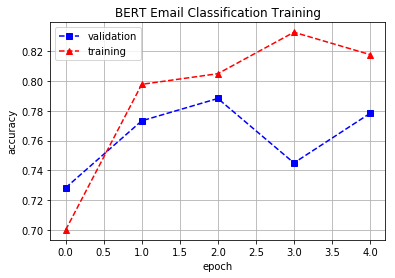

In [106]:
import matplotlib.pyplot as plt

df_history = pd.DataFrame(history.history)
fig,ax = plt.subplots()
plt.plot(range(df_history.shape[0]),df_history['val_acc'],'bs--',label='validation')
plt.plot(range(df_history.shape[0]),df_history['acc'],'r^--',label='training')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('BERT Email Classification Training')
plt.legend(loc='best')
plt.grid()
plt.show()

fig.savefig('BERTConvergence.eps', format='eps')
fig.savefig('BERTConvergence.pdf', format='pdf')
fig.savefig('BERTConvergence.png', format='png')
fig.savefig('BERTConvergence.svg', format='svg')

**Make figures downloadable to local system in interactive mode**

In [107]:
from IPython.display import HTML
def create_download_link(title = "Download file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

create_download_link(filename='BERTConvergence.svg')

In [108]:
!ls
!rm -rf aclImdb
!rm aclImdb_v1.tar.gz

BERTConvergence.eps  BERTConvergence.svg  kaggle_image_requirements.txt
BERTConvergence.pdf  aclImdb
BERTConvergence.png  aclImdb_v1.tar.gz
